### Project Charter
The intent of the project is to predict the future state of current loans as **Fully Paid or Default**. This is supposed to be achieved through training the classification algorithms on labeled data (Fully Paid & Default) and then making predictions on the dataset which contains current loans. This exercise is being done for Finance & Risk teams at Lending Club to accurately identify the end state of a loan, thus helping them with accurate revenue forecasting and risk mitigation.

### Data
[Dataset](https://www.kaggle.com/wendykan/lending-club-loan-data) used for the project, this file contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. The file is a matrix of about 890 thousand observations and 75 variables.

### Data Wrangling
To begin with data was structured and available in a delimited file, thus initial consumption of data was straightforward. Based on EDA, there was a need to transform existing data into a format more conducive for modelling. Following attributes were derived from one or more than one attribute,
- loan_status_bin, to condense related loan statuses into a single category
- replace absent annual income with median annual income
- derive numerical credit_grade from textual value
- derive derived_income from a combination of application type, annual  income, and joint annual income
- derive derived_dti from a combiation of application type, dti, and joint dti

### Exploratory Data Analysis
Exploratory data analysis was performed to identify correlation of various customer and loan attributes with the status of the loan; and also to identify the strength of relationship between various customer and loan attributes to develop an understanding of Lending Club customers, their reasons for taking out loan, and the type of loan they take out.  

### Inferential Statistics
As part of inferential statistics I evaluated my hypothesis about signal strength between annual income and loan status (_Fully Paid or Default_)

### Feature Engineering
Since all the features do not impact the outcome of the loan, neither do they impact the outcome of the loan equally, I worked on selecting a subset of features which correlated most strongly with the status of the loan, and used them in training the classifiers.

### Model Selection
I started with a naive Logistic Classifier, then slowly worked my way through the models with increasing complexity, Logistic Classifier with C, CART, Random Forest, XGBoost and captured their performance metrics.

### Model Evaluation
I compared the performance metrics of above models to select the best models to tune their hyper parameters to increase their accuracy.

### Class Imabalance/ Resampling
While looking at the Classification reports, I realized that there is a sever class imabalance between Default (x) and Fully Paid (10x) and thus models were better at learning features for Fully Paid loans, to overcome this challenge I used[SMOTE](https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html) to resample data to equalize sample size in **training data**

### Hyper Parameter Tuning
I employed techiniques such as RandomSearhCV & GridSearchCV to find the most optimal set of heyper parameters for multiple models.

### Client Recommendations
1. More training data especially for Default samples
2. Deploy the best current model in production as a pilot and evaluate in live environment.
3. Restructure the problem as a regression problem and rate the outcome of a loan on scale of 0 to 1 rather than a binary outcome

### Future Work
1. Gather more training data
2. Try ensembling/ stacking of models.
3. Try [deep learning techniques for tabular data](http://www.fast.ai/2018/04/29/categorical-embeddings/)


### Import necessary modules

In [1]:
import numpy as np
from numpy import loadtxt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('max_columns', None)

from scipy import stats
from scipy.stats import probplot
from scipy.stats.mstats import zscore

import statsmodels.stats.api as sms
import nltk

import collections as co
from collections import Counter
from collections import OrderedDict

from sklearn import datasets
from sklearn.datasets import make_classification

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler

from xgboost import XGBClassifier

#from dask_ml.model_selection import GridSearchCV

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import in

### [Google Colab](https://colab.research.google.com/) specific section to run XGBoost 

In [ ]:
!pip install -U -q imbalanced-learn
!pip install -U -q PyDrive

In [ ]:
# Code to read csv file into colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#2. Get the file
downloaded = drive.CreateFile({'id':'1iZ6FE7L8uAXOIi92PT9sosHcUUA2m8Cs'}) #get the token from execution of previous cell
downloaded.GetContentFile('loan.csv')  

In [3]:
#read loans.csv as a dataframe
loans_df = pd.read_csv('loan.csv',low_memory=False, engine='c')

### Read file and create dataframe

In [7]:
loans_df = pd.read_csv('~/Downloads/tanay/data_springboard/loan.csv',low_memory=False, engine='c')

### Inspect Dataframe

In [4]:
loans_df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,887350.000000,433067.000000,137053.000000,887350.000000,887350.000000,8.873790e+05,886877.000000,887350.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887234.000000,221703.000000,887379.0,511.000000,509.000000,887350.000000,8.171030e+05,8.171030e+05,21372.000000,21372.000000,21372.000000,21372.000000,20810.000000,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171030e+05,21372.000000,21372.000000,21372.000000
mean,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,0.694623,34.063798,70.117903,11.548469,0.195307,1.692079e+04,55.067693,25.268026,8403.124852,8399.713242,7558.826684,7521.160306,5757.706424,1754.804327,0.396692,45.919243,4.880757,2164.145585,0.014380,44.104838,1.0,109981.011585,18.310118,0.004991,2.257026e+02,1.394582e+05,1.109021,2.928832,0.761651,1.674574,20.912686,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206862e+04,0.943945,1.537058,1.977307
std,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,0.998448,21.884940,28.127914,5.317313,0.582091,2.242679e+04,23.834344,11.840561,8493.450269,8489.997617,7871.243336,7846.108604,6625.441046,2095.356099,4.087825,409.693874,63.125281,4794.783233,0.134191,22.179841,0.0,52730.379847,7.169233,0.077625,1.031137e+04,1.537500e+05,1.242675,3.089987,0.996035,1.688725,27.209081,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749826e+04,1.446872,2.723339,2.874067
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,17950.000000,3.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,6.443000e+03,37.700000,17.000000,0.000000,0.000000,1914.590000,1899.700000,1200.570000,441.460000,0.000000,0.000000,0.000000,280.170000,0.000000,27.000000,1.0,76032.500000,13.200000,0.000000,0.000000e+00,2.985300e+04,0.000000,1.000000,0.000000,0.000000,6.000000,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000
50%,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,1.187500e+04,56.000000,24.000000,6458.290000,6455.810000,4894.999117,4862.010000,3215.320000,1073.280000,0.000000,0.000000,0.000000,462.780000,0.000000,44.000000,1.0,101771.000000,17.610000,0.000000,0.000000e+00,8.055900e+04,1.000000,2.000000,0.000000,1.000000,12.000000,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.0000

In [9]:
loans_df['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

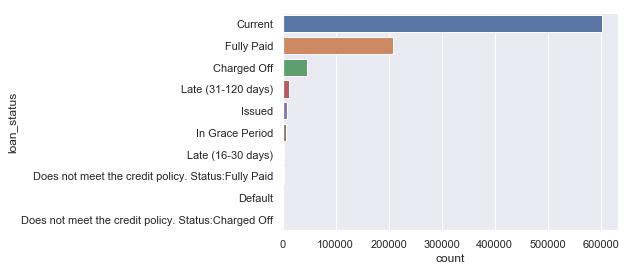

In [10]:
sns.set(style='darkgrid')
_=sns.countplot(y='loan_status', data=loans_df, order = loans_df['loan_status'].value_counts().index, orient='h')

### Creation of new features based on translation of existing features 

In [11]:
#define a function to classify loan status into one of the following bins ('Fully Paid', 'Default', 'Current')
def loan_status_bin(text):
    if text in ('Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'):
        return 'Fully Paid'
    elif text in ('Current', 'Issued'):
        return 'Current'
    elif text in ('Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period'):
        return 'Default'
    else:
        'UNKNOWN BIN'

In [12]:
#create a new attribute 'loan_status_bin' in the dataframe
loans_df['loan_status_bin']=loans_df['loan_status'].apply(loan_status_bin)
loans_df['loan_status_bin'].unique()

array(['Fully Paid', 'Default', 'Current'], dtype=object)

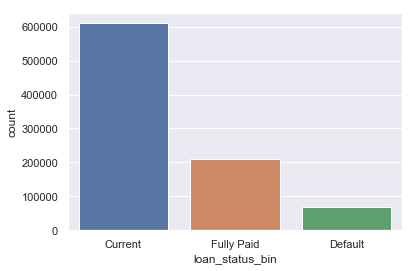

In [13]:
sns.set(style='darkgrid')
_=sns.countplot(x='loan_status_bin', data=loans_df, order = loans_df['loan_status_bin'].value_counts().index)

In [30]:
# Fill null annual income by median annual income
loans_df.fillna(loans_df['annual_inc'].median()
                , inplace=True)

In [15]:
loans_df[loans_df['annual_inc'].isnull()==True]['annual_inc'].count()

0

In [16]:
# create a new dataframe for Fully Paid loans
loans_df_fp=loans_df[loans_df['loan_status_bin']=='Fully Paid']

In [17]:
# create a new dataframe for Current loans
loans_df_def=loans_df[loans_df['loan_status_bin']=='Default']

In [18]:
print('For Default loans, mean annual income is {0}, standard deviation is {1}, size of dataframe is {2}'.format(loans_df_def['annual_inc'].mean(), loans_df_def['annual_inc'].std(), len(loans_df_def['annual_inc'])))

For Default loans, mean annual income is 67324.66868350415, standard deviation is 64812.91039063109, size of dataframe is 67429


In [19]:
print('For Fully Paid loans, mean annual income is {0}, standard deviation is {1}, size of dataframe is {2}'.format(loans_df_fp['annual_inc'].mean(), loans_df_fp['annual_inc'].std(), len(loans_df_fp['annual_inc'])))

For Fully Paid loans, mean annual income is 74142.5024192341, standard deviation is 59205.29202398379, size of dataframe is 209711


In [20]:
#define a function to convert grade into numerical values
def credit_grade(grade):
    if grade in ('A'):
        return 1
    elif grade in ('B'):
        return 2
    elif grade in ('C'):
        return 3
    elif grade in ('D'):
        return 4
    elif grade in ('E'):
        return 5
    elif grade in ('F'):
        return 6
    elif grade in ('G'):
        return 7
    else:
        99

In [31]:
#create a new attribute 'credit_grade' in the dataframe
loans_df['credit_grade']=loans_df['grade'].apply(credit_grade)
loans_df['credit_grade'].unique()

array([2, 3, 1, 5, 6, 4, 7])

In [22]:
loans_df['application_type'].unique()

array(['INDIVIDUAL', 'JOINT'], dtype=object)

In [23]:
def derived_income(x, y, z):
    if x == 'INDIVIDUAL':
        return y
    elif x == 'JOINT':
        return z
    else:
        0

In [24]:
#create a feature derived income, which chooses between annual income & joint annual income based on the application type
loans_df['derived_income']=loans_df.apply(lambda x: derived_income(x['application_type'], x['annual_inc'], x['annual_inc_joint']), axis=1)

In [25]:
def derived_dti(x, y, z):
    if x == 'INDIVIDUAL':
        return y
    elif x == 'JOINT':
        return z
    else:
        0

In [26]:
#create a feature derived DTI, which chooses between DTI & jjoint DTI based on the application type
loans_df['derived_dti']=loans_df.apply(lambda x: derived_dti(x['application_type'], x['dti'], x['dti_joint']), axis=1)

In [27]:
# create a feature which tracks the ratio of installment to derived income
loans_df['inst_inc_ratio']=loans_df['installment']/ (loans_df['derived_income'] /12)

## Model Training

Features used in the current modelling: 
* loan_amount
* credit_grade 
* interest_rate 
* derived_inc
* derived_dti 
* inst_inc_ratio

### Training and Test Datasets

When fitting models, we would like to ensure two things:

* We have found the best model (in terms of model parameters).
* The model is highly likely to generalize i.e. perform well on unseen data.

<br/>
<div class="span5 alert alert-success">
<h4>Purpose of splitting data into Training/testing sets</h4>
<ul>
  <li> We built our model with the requirement that the model fit the data well. </li>
  <li> As a side-effect, the model will fit <b>THIS</b> dataset well. What about new data? </li>
    <ul>
      <li> We wanted the model for predictions, right?</li>
    </ul>
  <li> One simple solution, leave out some data (for <b>testing</b>) and <b>train</b> the model on the rest </li>
  <li> This also leads directly to the idea of cross-validation, next section. </li>  
</ul>
</div>

First, we try a basic Logistic Regression:

* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [32]:
#create a dataframe which has Fully Paid and Default loans in it to be used for training.
loans_df_fp_def=loans_df[loans_df['loan_status_bin'].isin(['Fully Paid', 'Default'])]

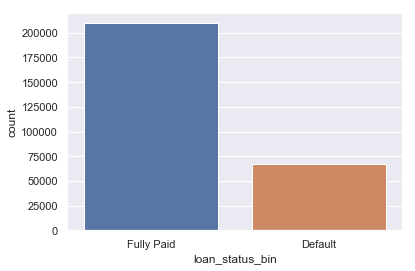

In [33]:
sns.set(style='darkgrid')
_=sns.countplot(x='loan_status_bin', data=loans_df_fp_def, order = loans_df_fp_def['loan_status_bin'].value_counts().index)

### Split the data into a training and test set.

In [80]:
X, y = loans_df_fp_def[['loan_amnt', 'credit_grade', 'int_rate', 'derived_income', 'derived_dti', 'inst_inc_ratio']].values, (loans_df_fp_def.loan_status_bin).values

In [81]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, random_state=5, stratify=y)

In [36]:
loans_df_curr=loans_df[loans_df['loan_status_bin'].isin(['Current'])]

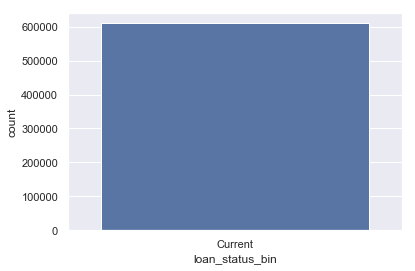

In [37]:
sns.set(style='darkgrid')
_=sns.countplot(x='loan_status_bin', data=loans_df_curr, order = loans_df_curr['loan_status_bin'].value_counts().index)

### Build a logistic regression classifier (naive)

In [38]:
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.7567005845421086


### Tuning the Classifier

The model has some hyperparameters we can tune for hopefully better performance. For tuning the parameters of your model, you will use a mix of *cross-validation* and *grid search*. In Logistic Regression, the most important parameter to tune is the *regularization parameter* `C`. Note that the regularization parameter is not always part of the logistic regression model. 

The regularization parameter is used to control for unlikely high regression coefficients, and in other cases can be used when data is sparse, as a method of feature selection.

You will now implement some code to perform model tuning and selecting the regularization parameter $C$.

We use the following `cv_score` function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.


In [42]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

Below is an example of using the `cv_score` function for a basic logistic regression model without regularization.

In [43]:
clf1 = LogisticRegression()
score = cv_score(clf1, Xlr, ylr)
print(score)

0.7566957734959467


<div class="span5 alert alert-info">

<b>Exercise:</b> Implement the following search procedure to find a good model
<ul>
<li> For a given a list of possible values of `C` below
<li> For each C:
  <ol>
  <li> Create a logistic regression model with that value of C
  <li> Find the average score for this model using the `cv_score` function **only on the training set** `(Xlr, ylr)`
  </ol>
<li> Pick the C with the highest average score
</ul>
Your goal is to find the best model parameters based *only* on the training set, without showing the model test set at all (which is why the test set is also called a *hold-out* set).
</div>

In [47]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
max_score=0

for C in Cs:
    clf2 = LogisticRegression(C=C)
    score = cv_score(clf2, Xlr, ylr)
    if score > max_score:
        max_score = score
        best_C =C
print ('max_score: {0}, best_C: {1}'.format(max_score, best_C))

max_score: 0.7566957734959467, best_C: 0.001


<ol>
<li> Use the C you obtained from the procedure earlier and train a Logistic Regression on the training data
<li> Calculate the accuracy on the test data
</ol>

In [46]:
clf3=LogisticRegression(C=best_C)
clf3.fit(Xlr, ylr)
ypred=clf3.predict(Xtestlr)
print('accuracy score: ', accuracy_score(ypred, ytestlr), '\n')

accuracy score:  0.7567005845421086 



### Black Box Grid Search in `sklearn` on Logistic Regression
Use scikit-learn's [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) tool to perform cross validation and grid search. 

* Instead of writing your own loops above to iterate over the model parameters, use GridSearchCV to find the best model over the training set? 
* Does it give you the same best value of `C`?
* How does this model you've obtained perform on the test set?

In [51]:
clf4=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clf4, param_grid=parameters, cv=5, scoring="accuracy", return_train_score=True)
fitmodel.fit(Xlr, ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.cv_results_

clf5=LogisticRegression(C=fitmodel.best_params_['C'])
clf5.fit(Xlr, ylr)
ypred=clf5.predict(Xtestlr)

print('accuracy score: ', accuracy_score(ypred, ytestlr))
print('The new value of the C is: ', fitmodel.best_params_['C'])

accuracy score:  0.7567005845421086
The new value of the C is:  0.0001


#### Decision Tree Classifier (naive)

In [54]:
# fit a CART model to the data
clf_dt = DecisionTreeClassifier()
clf_dt.fit(Xlr, ylr)
print(clf_dt)
# make predictions
ypred = clf_dt.predict(Xtestlr)
# summarize the fit of the model
print(metrics.classification_report(ytestlr, ypred))
print(metrics.confusion_matrix(ytestlr, ypred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
             precision    recall  f1-score   support

    Default       0.31      0.33      0.32     16857
 Fully Paid       0.78      0.77      0.77     52428

avg / total       0.67      0.66      0.66     69285

[[ 5532 11325]
 [12153 40275]]


## Resampling of Data

Since we already know that number of observations for **Default** is less than half of **Fully Paid**, we can see the impact of this uneven distribution in the precision and other metrics from classification report, and thus it becomes imperative to balance the classes by employing a resamping technique.

### Resampling using SMOTE

In [82]:
X_resampled, y_resampled = SMOTE().fit_sample(Xlr, ylr)
print(sorted(Counter(y_resampled).items()))

[('Default', 157283), ('Fully Paid', 157283)]


In [83]:
X_test_resampled, y_test_resampled = SMOTE().fit_sample(Xtestlr, ytestlr)
print(sorted(Counter(y_test_resampled).items()))

[('Default', 52428), ('Fully Paid', 52428)]


### Training a classifier (logistic regression) using SMOTE resampled data

In [59]:
clf_smote = LogisticRegression().fit(X_resampled, y_resampled)
print(clf_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [60]:
# make predictions
ypred = clf_smote.predict(Xtestlr)
# summarize the fit of the model
print(metrics.classification_report(ytestlr, ypred))
print(metrics.confusion_matrix(ytestlr, ypred))

             precision    recall  f1-score   support

    Default       0.30      0.76      0.44     16857
 Fully Paid       0.85      0.44      0.58     52428

avg / total       0.72      0.52      0.55     69285

[[12872  3985]
 [29359 23069]]


In [61]:
print('accuracy score: ', accuracy_score(ypred, ytestlr), '\n')

accuracy score:  0.518741430324024 



### Training Decision tree (CART) using SMOTE sampled data

In [63]:
# fit a CART model to the data
clf_dt_smote = DecisionTreeClassifier()
clf_dt_smote.fit(X_resampled, y_resampled)
print(clf_dt_smote)
# make predictions
ypred = clf_dt_smote.predict(Xtestlr)
# summarize the fit of the model
print(metrics.classification_report(ytestlr, ypred))
print(metrics.confusion_matrix(ytestlr, ypred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
             precision    recall  f1-score   support

    Default       0.31      0.34      0.32     16857
 Fully Paid       0.78      0.75      0.76     52428

avg / total       0.66      0.65      0.66     69285

[[ 5774 11083]
 [13089 39339]]


## Training Random forest using SMOTE sampled data

In [68]:
clf_rf_1 = RandomForestClassifier(max_depth=5, random_state=0)

In [69]:
clf_rf_1.fit(X_resampled, y_resampled)
print(clf_rf_1.feature_importances_)

[0.00788212 0.65707935 0.240958   0.00816264 0.04317551 0.04274238]


In [70]:
print(clf_rf_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [71]:
# make predictions
ypred = clf_rf_1.predict(Xtestlr)
# summarize the fit of the model
print(metrics.classification_report(ytestlr, ypred))
print(metrics.confusion_matrix(ytestlr, ypred))

             precision    recall  f1-score   support

    Default       0.38      0.54      0.45     16857
 Fully Paid       0.83      0.71      0.77     52428

avg / total       0.72      0.67      0.69     69285

[[ 9143  7714]
 [14987 37441]]


### Hyperparameter tuning

#### Hyper parameter tuning of Random Forest using Randomized Search CV

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
print(random_grid)

{'n_estimators': [200, 650, 1100, 1550, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 32, 55, 77, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf_rf_2 = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = clf_rf_2, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=77, bootstrap=False 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=77, bootstrap=False 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=77, bootstrap=False 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=77, bootstrap=False, total= 6.5min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=77, bootstrap=False, total= 7.1min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=None, boots

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 360.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [200, 650, 1100, 1550, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 32, 55, 77, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [ ]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=55, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
rf_random.cv_results_

{'mean_fit_time': array([  383.12628023,  5140.30518508,  1132.78761164,  1436.26093531,
          528.25576274,   914.40572794,  1276.98479168,   279.51547917,
         5309.87085724,  2701.06569139]),
 'mean_score_time': array([   30.56938227,  1093.70888766,   138.91831342,   716.05484041,
           15.2453169 ,    30.58743819,   146.24274071,    15.88703672,
         1700.91918516,   522.30573805]),
 'mean_test_score': array([ 0.77174196,  0.77273276,  0.76145609,  0.76807411,  0.76715952,
         0.73779764,  0.7719325 ,  0.76102103,  0.77295505,  0.76394261]),
 'mean_train_score': array([ 0.99983804,  0.9998571 ,  0.94190976,  0.98733082,  0.98658296,
         0.76829323,  0.99957764,  0.93498847,  0.99996189,  0.95725918]),
 'param_bootstrap': masked_array(data = [False False True True True True False True False True],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_max_depth': masked_array(data = [77 None 32

#### Hyper parameter tuning of Random Forest using Grid Search CV

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [45, 55, 65, 70],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1900, 2000, 2100]
}

# Create a base model
rf = RandomForestClassifier(random_state = 42)

In [44]:
print(param_grid)

{'bootstrap': [False], 'max_depth': [45, 55, 65, 70], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 3, 4], 'n_estimators': [1900, 2000, 2100]}


In [ ]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, return_train_score=True, verbose=4)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

### Classification (Random Forest) with Scaling

In [84]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('rfc', RandomForestClassifier())]

#X_resampled, y_resampled
#Xtestlr, ytestlr
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: knn_scaled
knn_scaled = pipeline.fit(X_resampled, y_resampled)

# Instantiate and fit a k-NN classifier to the unscaled data
knn_unscaled = RandomForestClassifier().fit(X_resampled, y_resampled)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(knn_scaled.score(Xtestlr, ytestlr)))
print('Accuracy without Scaling: {}'.format(knn_unscaled.score(Xtestlr, ytestlr)))

Accuracy with Scaling: 0.6875947174713142
Accuracy without Scaling: 0.6887926679656491


### Gradient Boosting using XGBoost

#### XGBoost classifier (naive)

In [48]:
model = XGBClassifier()
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [49]:
# make predictions for test data
# Xtestlr, ytestlr
y_pred = model.predict(Xtestlr)
# evaluate predictions
accuracy = accuracy_score(ytestlr, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.41%


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
model.feature_importances_

array([0.06033183, 0.50980395, 0.20361991, 0.05580694, 0.10105581,
       0.0693816 ], dtype=float32)

#### XGBoost using early stopping

In [53]:
# fit model on training data
xgb = XGBClassifier()
eval_set = [(Xtestlr, ytestlr)]
xgb.fit(X_resampled, y_resampled, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.674542
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.65959
[2]	validation_0-logloss:0.647495
[3]	validation_0-logloss:0.637671
[4]	validation_0-logloss:0.629663
[5]	validation_0-logloss:0.623125
[6]	validation_0-logloss:0.617781
[7]	validation_0-logloss:0.613406
[8]	validation_0-logloss:0.609829
[9]	validation_0-logloss:0.606323
[10]	validation_0-logloss:0.603409
[11]	validation_0-logloss:0.601319
[12]	validation_0-logloss:0.599124
[13]	validation_0-logloss:0.597224
[14]	validation_0-logloss:0.591411
[15]	validation_0-logloss:0.589108
[16]	validation_0-logloss:0.587543
[17]	validation_0-logloss:0.585386
[18]	validation_0-logloss:0.58196
[19]	validation_0-logloss:0.580544
[20]	validation_0-logloss:0.57676
[21]	validation_0-logloss:0.575418
[22]	validation_0-logloss:0.574052
[23]	validation_0-logloss:0.572041
[24]	validation_0-logloss:0.571154
[25]	validation_0-logloss:0.570345
[26]	validation_0-logloss:0.569564


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [54]:
# make predictions for test data
y_pred = xgb.predict(Xtestlr)
# evaluate predictions
accuracy = accuracy_score(ytestlr, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.41%


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Hyper Parameter tuning for XGBoost

In [ ]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold,
verbose=1)
result = grid_search.fit(X_resampled, y_resampled)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.2min


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#### OOB Errors for Random Forests¶

In [ ]:
print(__doc__)

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 1500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_resampled, y_resampled)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

### Predict loan status for loans with status = 'Current'

In [72]:
loans_df_curr['loan_status_pred']=clf_rf_1.predict(loans_df_curr[['loan_amnt', 'credit_grade', 'int_rate', 'derived_income', 'derived_dti', 'inst_inc_ratio']])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


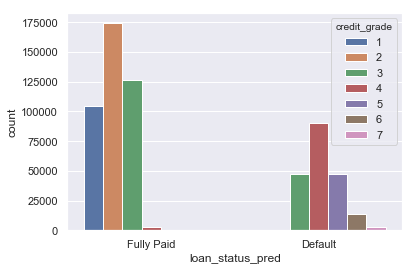

In [73]:
sns.set(style='darkgrid')
_=sns.countplot(x='loan_status_pred', data=loans_df_curr, order = loans_df_curr['loan_status_pred'].value_counts().index, hue='credit_grade')